**<h1>Wine Classification Task</h1>**
**<h2>Predicting Country of Origin Based on Reviews</h2>**
<h4>Candidate: Can Orman</h4>

**Summary and Key Findings:** In this Jupyter Notebook file, we experiment with using traditional and LLM aided NLP techniques to process text-based variables to predict the country of origin of wine bottles. We explore thee ways of processing description texts: using traditional NLP with TF-IDF, using TF-IDF enhanced with LLMs, and using LLMs to directly create features, effectively replacing traditional NLP methods. We also experiment with how one-hot encoding can be improved by leveraging domain knowledge supplied by the LLM by grouping closely related categories together. We find in our results that the ML model with the greatest performances uses TF-IDF enhanced with LLMs, and an LLM-grouped one-hot encoding.

The structure of the notebook is as follows:
* `Part 0`: Setup and Initialisation
* `Part 1`: Data Exploration and Analysis
* `Part 2`: Creating a Baseline Model with Traditional NLP
* `Part 3`: Using LLM to Process the Description Variable
* `Part 4`: Using LLM to Enhance the Variety Variable
* `Part 5`: Results and Discussion

Note that the evaluation of ML models is only discussed in Part 5

**<h2> Part 0: Setup and Initialisation </h2>**

### Library Setup
Before running the code, ensure all required libraries are installed and ready for use. Key libraries include:
- **Data Manipulation**: `pandas`, `numpy`
- **Model Building**: `scikit-learn`, `imbalanced-learn`
- **Visualization**: `matplotlib`
- **Natural Language Processing**: `nltk`, `scikit-learn` (`TfidfVectorizer`)
- **API Integration**: `requests`, `openai`

Run the following command to install all required libraries
```bash
%pip install pandas numpy scikit-learn seaborn nltk imbalanced-learn openai requests
```

### Key Setup:
- API connection to a Language Model (LLM) is implemented using the `requests` library.
- **API Key**: Ensure your API key is stored securely and properly configured.


We define the `query_llm` function to facilitate interaction with the LLM API for text-based tasks like description analysis. It accepts a prompt and interacts with the API to fetch results.

Before we begin, we first load the dataset (`wine_quality_1000.csv`) and print the first few rows to understand its structure.

In [649]:
# The command below shows all required libraries, ensure all are installed before use
# %pip install pandas numpy scikit-learn seaborn nltk imbalanced-learn openai requests

import pandas as pd
import numpy as np
import seaborn as sns
import os
import requests
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

API_KEY = "r10V4zMKNyasNYn5Pyw598QW22iXONXA1GXmxaIL"  
API_URL = "https://candidate-llm.extraction.artificialos.com/v1/chat/completions"

# Function to send a request to the LLM API
def query_llm(prompt, model="gpt-4o-mini"):
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "x-api-key": API_KEY,
    }
    data = {
        "model": model,
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.7,
        "max_tokens": 800,
    }
    
    response = requests.post(API_URL, headers=headers, json=data)
    
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

# Load the uploaded dataset
file_path = 'wine_quality_1000.csv'
wine_data = pd.read_csv(file_path)
wine_data = wine_data[['country', 'description', 'points', 'price', 'variety']]

# Display the first few rows of the dataset to understand its structure
wine_data.head()


,country,description,points,price,variety
0,US,"Very good Dry Creek Zin, robust and dry and sp...",89,25.0,Zinfandel
1,France,A very herbaceous character makes this wine se...,84,20.0,Bordeaux-style White Blend
2,US,"A little simple and easy, but there's a wealth...",84,19.0,Rosé
3,US,From a dry-farmed vineyard and treated to wild...,88,38.0,Petite Sirah
4,US,"From a site near Annapolis, this wine shows a ...",91,62.0,Pinot Noir


**<h2> Part 1: Data Exploration and Analysis </h2>**

Before using data visualisation techniques to examine the trends and patterns of wines from different countries, it is useful to intially obeserve the dataset and gain some immediate intuition about the predictor variables. This will help us understand what data is most useful to visualise. Let's begin by observing each variable:

- `Variety`: Certain grape varieties are strongly associated with specific countries. For example: Zinfandel is typically produced in the United States, and wines like champagne is regional to France. Certain variety of wines can therefore be a direct predictor of a wine's country of origin as it is explicitly linked towards the country.

- `Description`: Descriptions often contain region-specific terms or tasting notes that directly indicate the country. For example: Words like “Bordeaux” suggest France, and mentions of “Napa Valley” or “Sonoma” point to the United States. Although some descriptions are generic, many descriptions can be a direct giveaway to where a bottle of wine through its referencing of country-specific terms.

- `Points`: Points reflect wine quality but are not explicitly tied to a specific country. Certain countries or regions have reputations for higher or lower scores due to industry standards or critics’ biases. For example: French and Italian wines may score highly due to established reputations. However, there will likely be many wines with similar points throughout all countries, this overlap makes points an indirect predictor as it indicates a trend rather than a fixed pattern.

- `Price`: Price varies based on production costs, taxes, and other market factors. For example: French wines, such as Bordeaux or Burgundy, often command higher prices, indirectly signaling France. Affordable, high-quality wines from Spain may reflect their origin through price. However, similar to the Points variable, there will likely be wines with similar costs throughout all countries, showing that price as an indirect predictor.

Overall, points and price may give us some general clues of the origins of wines, but variety and description may provide decisive information that indicates the origin of wines. To confirm if this is true, let's create some visualisations to show the distribution of points and prices for wine bottles in each country.

We can also visualise the varieties of wine bottles for each country, and print out key statistics. To interpret the description, we can use TF-IDF to understand what are the most significant words that correspond to each country.

/var/folders/c7/b646ch897kx__bjbm501_jk80000gp/T/ipykernel_79382/129189871.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=wine_data, x='country', y='points', palette="coolwarm")


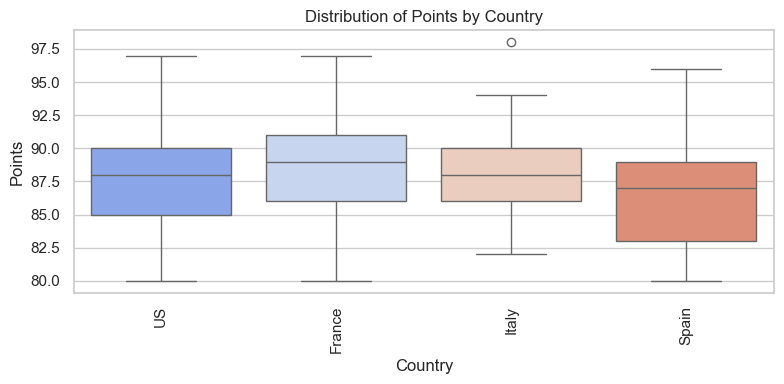

/var/folders/c7/b646ch897kx__bjbm501_jk80000gp/T/ipykernel_79382/129189871.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=wine_data, x='country', y=np.log1p(wine_data['price']), palette="viridis")


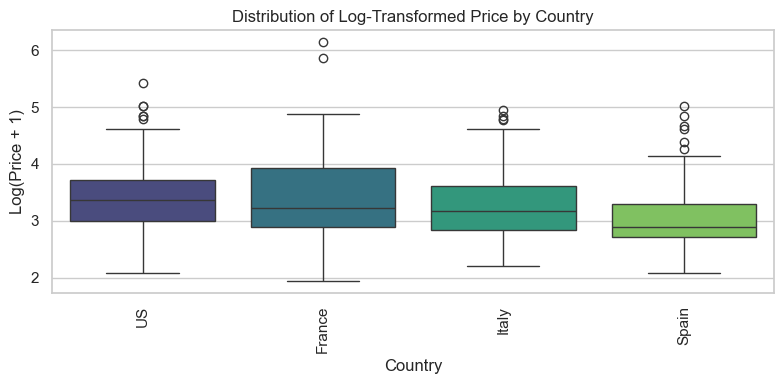

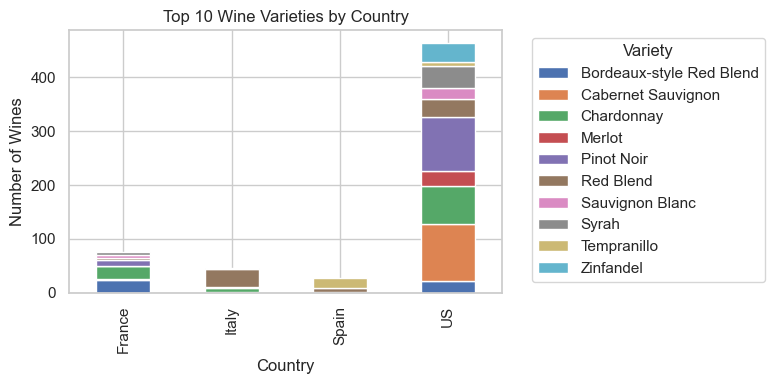

In [654]:
sns.set(style="whitegrid")

# Distribution of wine ratings (points) by country
plt.figure(figsize=(8, 4))
sns.boxplot(data=wine_data, x='country', y='points', palette="coolwarm")
plt.xticks(rotation=90)
plt.title('Distribution of Points by Country')
plt.xlabel('Country')
plt.ylabel('Points')
plt.tight_layout()
plt.show()

# Distribution of wine prices by country
plt.figure(figsize=(8, 4))
sns.boxplot(data=wine_data, x='country', y=np.log1p(wine_data['price']), palette="viridis")
plt.xticks(rotation=90)
plt.title('Distribution of Log-Transformed Price by Country')
plt.xlabel('Country')
plt.ylabel('Log(Price + 1)')
plt.tight_layout()
plt.show()

# Variety count by country (Top 10 varieties)
top_varieties = wine_data['variety'].value_counts().head(10).index
variety_by_country = wine_data[wine_data['variety'].isin(top_varieties)].groupby(['country', 'variety']).size().unstack()
variety_by_country.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Top 10 Wine Varieties by Country')
plt.ylabel('Number of Wines')
plt.xlabel('Country')
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common stop words
    max_features=1000,     # Limit to top 1000 terms
    ngram_range=(1, 2)     # Use unigrams and bigrams
)

# Fit and transform the descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(wine_data['description'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)
tfidf_df.head()
tfidf_with_country = pd.concat([pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names), wine_data['country']], axis=1)
country_tfidf = tfidf_with_country.groupby('country').sum() # Group by 'country' and sum TF-IDF scores for each term
top_n = 10 
most_significant_words = {}

for country in country_tfidf.index: # Find the top N most significant words for each country
    top_terms = country_tfidf.loc[country].sort_values(ascending=False).head(top_n) # Sort the terms by their TF-IDF scores in descending order
    most_significant_words[country] = top_terms

# Display the most significant words for each country
for country, terms in most_significant_words.items():
    print(f"\nMost significant words for {country}:")
    print(terms)


Most significant words for France:
wine         12.497901
fruits        7.664711
acidity       7.261290
fruit         6.211555
tannins       5.865628
wood          5.736587
ripe          5.687038
texture       5.184869
richness      4.915848
character     4.741203
Name: France, dtype: float64

Most significant words for Italy:
aromas    9.771601
fruit     9.372512
wine      8.808756
spice     8.106512
bright    6.888036
cherry    6.718708
palate    6.211676
offers    5.688820
berry     5.439149
mouth     5.427930
Name: Italy, dtype: float64

Most significant words for Spain:
aromas     5.089408
flavors    4.565630
palate     4.381369
finish     4.373047
nose       3.279685
fruit      3.201882
green      2.619074
wine       2.520529
berry      2.249745
feels      2.201454
Name: Spain, dtype: float64

Most significant words for US:
flavors    35.604435
wine       28.339483
fruit      22.334719
cherry     21.343451
dry        20.732592
tannins    19.081985
acidity    18.269633
sweet     

**<h4> Key Observations:</h4>**

- `Price`: Price is likely a valuable feature for predicting country of origin, especially for distinguishing premium wine-producing countries like France from more affordable ones such as Spain. However, as the box plot shows significant overlap in price distribution between countries, its effectiveness likely relies on combining price with other relevant features to account for overlapping price distributions.

- `Points`: France generally produces the highest-rated wines, while Spain shows slightly lower ratings on average. Italy exhibits more variability, including an exceptional outlier score. The US scores are consistent and competitive, but not as high as France. Similar to price, the box plot shows significant overlap in point distributions between countries. The effectiveness of points likely also relies in combining points with other relevent features. It is however likely a useful feature for predicting countries with many outliers such as Italy.

- `Variety`: The US produces significantly more wines across a wide variety, with Cabernet Sauvignon and Chardonnay being some of the most popular wines. Other countries are less diverse and tend to be more specialised, such as Spain's Tempranillo as its standard variety. Variety will therefore be a powerful predictor, especially for varieties that correlates to a country's regional specialty. However since US wines are incredibly diverse, the challenge will be categorising a countries generic wines that overlaps with commonly produced US varieties.

- `Description`: There are many keywords in descriptions that give us hints on the distinct wine styles for each country. **French** wines for example, are known for their elegance and complexity, often described with terms like "texture," "richness", "tannins", and "character". **Italian** wines, on the other hand, are vibrant and aromatic with fruity notes like "cherry" and "berry," often accompanied by "spice" and a "bright" and lively "palate". **Spanish** wines are approachable and well-rounded, focusing on "aromas," "flavors," and "palate" balance, described with grounded terms like "green" and "nose" indicating a more accessable and affordable wine. **US** wines are bold and fruit-driven, with intense "flavors," prominent "cherry" notes, and a distinshed "oak" flavour. They are the most diverse wines ranging from "dry" to "sweet". 

**<h4>Takeaways for designing the ML Model with Traditional and LLM NLP</h4>**

- **Overepresented Class**: The majority of the data is from the US (622 samples). This is a problem, as the ML model will likely be biased towards the dominant class (US) but struggle to predict other countries. To account for this, we will undersample the US class. This is likely not the best solution, as the US class is diverse with many different wine varieties, undersampling this will likley result in losing relevent information. However due to time constraints, I have chosen to use undersampling so I can focus on NLP techniques instead. It is worth mentioning that I have considered using LLM as a data augmentation tool to create new entries for underepresented classes, but have chosen not to due to time constraints and issues with LLM hallucinations.

- **Large Number of Vategories in `Variety`**: As previously discussed, variety is likely an effective feature for predicting the origin of wines. However there are a lot of unique wine varieties in the dataset, with a total of 105 different varieties. Additionally many wine varieties have a low count, with 75 out of 105 wines having a count of 5 or less. This may cause the ML model to struggle if the varieties of wines are processed using a one-hot encoding, resulting in a feature space with high dimensions. While it is possible to still get good results by encoding the variety as it is, we will use the LLM to experiment if we can reduce the dimensions of variety by grouping wine varieties together using domain knowledge. 

- **Key Words in `Description`**: As shown, the keywords in descriptions is highly relevent in distinguishing the profile of wines between countries. Therefore, using NLP to extract the significance of relevent words is crucial to the LLM. This has already been done using TF-IDF, but there may be ways to gain better performance with the aid of an LLM. We will experiment in using the LLM to enhance the peformance of TF-IDF by preprocessing descriptions to exclude any words that do not relate to a wines profile or origin. We will also experiment using the LLM to comput features directly from LLMs, therefore replacing TF-IDF as a new possible LLM NLP technique.

**<h2> Part 2: Creating a Baseline Model with Traditional NLP </h2>**

For our experiments, I have chosen to use **logistic regression** as a baseline model for this wine classification task. The reasoning for opting for a simpler baseline model is to emphasise the use of traditional NLP and LLM NLP technqiues, rather than meticulously optimising hyper parameters. Using this model makes it easy to compare and contrast these different NLP approaches, providing more interesting insights. However it is worth noting that if I were tasked to design an ML model for optimal predictability, I would select a decision tree or random forest. A multilayer perceptron may also be worth considering, but given the dataset is small ($<1000$ entries), it may run into issues with overfitting.

The first ML model will be created purely with traditional NLP techniques:
* The `description` variable is processed using TF-IDF
* The `variety` variable is processed using a one-hot encoding

Other than the feature transformations for `description` and `variety` rest of the machine learning workflow will be the same for each following experiment. This is so we can meaningfully compare the performance between different NLP techiques. The ML workflow is as follows:

### Summary of the Machine Learning Workflow

1. **Feature Transformation**:
   - **TF-IDF Vectorizer**: Applied to the `description` column to extract textual features with a maximum of 1000 terms and English stop words removed.
   - **One-Hot Encoding**: Encoded the `variety` column to represent categorical data as binary features.
   - **Standard Scaling**: Applied to the numerical columns `price` and `points` for normalisation.

2. **Train-Test Split**:
   - The dataset was split into training (80%) and testing (20%) subsets using stratified sampling to ensure balanced representation of the target classes.

3. **Model Pipeline**:
   - A `Pipeline` was created to streamline the workflow, consisting of:
     - **Preprocessor**: The feature transformations mentioned above.
     - **RandomUnderSampler**: Addressed class imbalance by undersampling the majority class to balance the dataset, setting the US class to 200 samples.
     - **Logistic Regression**: Trained a logistic regression classifier with a maximum of 500 iterations.

5. **Model Training and Evluation**:
   - The pipeline was fit on the training data (`X_train`, `y_train`) and predictions were made on the test set (`X_test`).
   - A classification report was generated, showing performance metrics (precision, recall, F1-score) for each class, and displayed as a DataFrame for better readability.

In [ ]:
X = wine_data[['price', 'points', 'description', 'variety']]
y = wine_data['country']

# TF-IDF Vectorizer for 'description'
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# One-Hot Encoder for 'variety'
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'description'),
        ('onehot', one_hot_encoder, ['variety']), 
        ('scaler', StandardScaler(), ['price', 'points'])  # Add scaling for numerical columns
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy= {'US': 200}, random_state=42)),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

model_pipeline.fit(X_train, y_train) # Train the model
y_pred = model_pipeline.predict(X_test) # Predict on the test set
classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose() # Evaluate the model
print(classification_report_df) # Display the classification report


              precision    recall  f1-score  support
France         0.580645  0.666667  0.620690   27.000
Italy          0.815789  0.885714  0.849315   35.000
Spain          0.700000  0.500000  0.583333   14.000
US             0.851240  0.830645  0.840816  124.000
accuracy       0.795000  0.795000  0.795000    0.795
macro avg      0.736919  0.720757  0.723539  200.000
weighted avg   0.797919  0.795000  0.794563  200.000


**<h2> Part 3: Using LLM to process the Description Variable </h2>**

### Method 1: LLM NLP
Now that we have our baseline ML model, we will modify this model to experiment how we can apply LLM NLP to the `description` variable. We will experiment with two different ways we can feature engineer the `description` variable, the first method is using the LLM to directly generate new features that we can directly include in the ML model.

The way this works is that we will prompt the LLM to read in a description. Using the description, we ask it to generate a dictionary of numerical feature values, where each value represents the predicted probability that the description corresponds to one of the four target classes. We can imagine the output values as the output of a softmax function. An example of the prompt is shown below:

In [656]:
# Example usage with single prompt
prompt = """
I am working on a wine classification task using a logistic regression model to predict the country of origin for wine bottles. The possible countries are the United States, Italy, Spain, and France. Each wine review in the dataset includes the following features: Price, Score, Description, Variety, and Country.

I would like you to analyse the Description of a wine bottle and output four numerical feature values. These values should represent the predicted probabilities of the wine being from each of the four countries (United States, Italy, Spain, and France). Ensure the probabilities are normalised so they sum to 1. The idea is that I will use your output as feature inputs for logistic regression.

Leverage your domain knowledge about wines to create these predicted probabilities. If there are clear references to regions or keywords that clearly indicate a country, give a more confident answer.

As a test, can you first output your response for this description: "Taurasi is a wine that flaunts a determined and powerful personality, and Fatica Contadina is no exception, thanks to its deep layers of spice, dark fruit, tobacco and cigar that it delivers to the senses. On the palate, it is austere and tightly structured."

Please format your response as a dictionary where keys are country names and values are the corresponding probabilities. You can give your probabilities up to two decimal places. For example:
{"US": 0.30, "Italy": 0.40, "Spain": 0.20, "France": 0.10}

"""
response = query_llm(prompt)

if response:
    print("Response from LLM:")
    print(response)


Response from LLM:
Based on the provided description of the wine, "Taurasi" is a key term that is strongly associated with Italian wine, specifically from the Campania region. The description also includes characteristics that are often found in Italian wines, such as deep layers of spice and dark fruit, which further supports this association. Therefore, we can confidently assign a higher probability to Italy.

Here’s the breakdown of the predicted probabilities for each country:

- **Italy**: Given the mention of "Taurasi" and the overall description that aligns with Italian wine characteristics, I would assign a strong probability.
- **United States**: There’s no indication of American wine characteristics, so this would be lower.
- **Spain**: While Spanish wines can share some characteristics, there is no direct reference to Spanish regions or styles in the description, so this would also be lower.
- **France**: Similar to Spain, there are no clear indicators that point towards Fre

As shown, the LLM is able to pick out key words like "Taurasi" and relate this to its corrsponding country Italy. If we look at the dataset, the country of the wine bottle with this description is indeed Italy. This LLM generated feature is promising, but in order to use this for our ML model we require to generate features for all data entries.

To do this, we write a function `process_batches` which prompts the LLM to generate responses for multiple descriptions at once. This is necessary as the response of LLMs are limited by the number of tokens available in the output (and I am also unsure if I have any limits to my API usage).

Additionally, processing the description in batches introduces a new tunable hyperparameter `batch_size`. There is a tradeoff between increasing and decreasing the batch size, smaller batch sizes means the LLM processes fewer descriptions at once, which reduces the risk of context dilution. Each description gets more "attention," leading to potentially higher-quality responses. However, more API calls are required to process the same number of descriptions, increasing time and cost.

Larger batches reduce the total number of API calls, saving time and cost, this can be well suited for large datasets. However since the LLM must process many descriptions in one prompt, the "focus" on each description might be diluted. This can lead to less precise or generic responses.

To balance between time and quality, I have selected an initial batch size of 5 to generate the LLM outputs.

The function `process_batches` additionally includes error handling in cases where the LLM fails to generate a correctly formatted response

In [ ]:
def process_batches(llm_prompt, data, batch_size=5, max_retries = 5):
   """
    Processes batches of wine descriptions using an LLM to generate preprocessed versions of the descriptions.
    Processes batches of wine descriptions using an LLM to generate features. 

    Parameters:
        llm_prompt (str): The prompt to use for the LLM.
        data (pd.Series): A Pandas Series containing wine descriptions.
        batch_size (int): Number of descriptions to process in each batch.
        max_retries (int): Maximum number of retries for processing a batch.

    Returns:
        list: A list of dictionaries where each dictionary contains the probability of a description corresponding to a country
    """
   results = [] # results stores the llm generated features
   batches = [data.iloc[i:i + batch_size] for i in range(0, len(data), batch_size)] # Create batches
   chunks = ["\n".join(batch.tolist()) for batch in batches] # Convert each batch into a single chunk of text separated by newlines
   
   for i, chunk in enumerate(chunks):
      retries = 0
      batch_results = None
      while retries < max_retries:
         try:
            batch_prompt = llm_prompt + "\nHere are " + str(batch_size) + " descriptions. Generate a response for each description. Ensure your output has exactly " + str(batch_size) + " dictionaries in the list:\n" + chunk
            probabilities = query_llm(batch_prompt)

            probabilities = eval(probabilities.strip())  # Convert LLM response to Python object

            if len(probabilities) != batch_size:
               raise ValueError(f"Batch {i + 1} returned {len(probabilities)} responses, expected {batch_size}.")

            if not isinstance(probabilities, list) or not all(isinstance(d, dict) for d in probabilities): # Ensure the response is valid
               raise ValueError(f"Invalid response format in batch {i + 1}")

            # If successful, assign batch_results and break the retry loop
            batch_results = probabilities
            break
    
         except Exception as e:
                print(f"Error processing batch {i + 1}, attempt {retries + 1}: {e}")
                retries += 1

      if batch_results:
         results.extend(batch_results)
      else: # Log the failed batch if retries are exhausted
         print(f"Batch {i + 1} failed after {max_retries} retries.")
      
   return results 

# Prompt for processing with batches
prompt = """
I am working on a wine classification task using a logistic regression model to predict the country of origin for wine bottles. The possible countries are the United States, Italy, Spain, and France. Each wine review in the dataset includes the following features: Price, Score, Description, Variety, and Country.

I would like you to analyse the Description of a wine bottle and output four numerical feature values. These values should represent the predicted probabilities of the wine being from each of the four countries (United States, Italy, Spain, and France). Ensure the probabilities are normalised so they sum to 1. The idea is that I will use your output as feature inputs for logistic regression.

Leverage your domain knowledge about wines to create these predicted probabilities. If there are clear references to regions or keywords that clearly indicate a country, give a more confident answer.

Please format your response as a list of dictionaries where keys are country names and values are the corresponding probabilities. You can give your probabilities up to two decimal places. For example:

[{"us_p": 0.05, "it_p": 0.75, "es_p": 0.10, "fr_p": 0.10}, ...]

Where each key represents the US, Italy Spain and France respectively.

The output of this LLM will be used directly, so please give me only the list of dictionaries
"""

llm_features = process_batches(prompt, wine_data['description'])
print (llm_features)

Error processing batch 54, attempt 1: Batch 54 returned 4 responses, expected 5.
Error processing batch 54, attempt 2: Batch 54 returned 4 responses, expected 5.
Error processing batch 54, attempt 3: Batch 54 returned 4 responses, expected 5.
[{'us_p': 0.8, 'it_p': 0.05, 'es_p': 0.05, 'fr_p': 0.1}, {'us_p': 0.1, 'it_p': 0.2, 'es_p': 0.1, 'fr_p': 0.6}, {'us_p': 0.1, 'it_p': 0.6, 'es_p': 0.2, 'fr_p': 0.1}, {'us_p': 0.2, 'it_p': 0.1, 'es_p': 0.1, 'fr_p': 0.6}, {'us_p': 0.75, 'it_p': 0.05, 'es_p': 0.1, 'fr_p': 0.1}, {'us_p': 0.3, 'it_p': 0.1, 'es_p': 0.1, 'fr_p': 0.5}, {'us_p': 0.05, 'it_p': 0.8, 'es_p': 0.1, 'fr_p': 0.05}, {'us_p': 0.7, 'it_p': 0.1, 'es_p': 0.1, 'fr_p': 0.1}, {'us_p': 0.1, 'it_p': 0.15, 'es_p': 0.1, 'fr_p': 0.65}, {'us_p': 0.4, 'it_p': 0.1, 'es_p': 0.1, 'fr_p': 0.4}, {'us_p': 0.85, 'it_p': 0.05, 'es_p': 0.05, 'fr_p': 0.05}, {'us_p': 0.1, 'it_p': 0.7, 'es_p': 0.1, 'fr_p': 0.1}, {'us_p': 0.05, 'it_p': 0.15, 'es_p': 0.7, 'fr_p': 0.1}, {'us_p': 0.05, 'it_p': 0.8, 'es_p': 0.1,

After generating features, we create a new .csv file to store the new features so we do not require to generate them again.

In [ ]:
llm_df = pd.DataFrame(llm_features)

if len(wine_data) != len(llm_df):
    raise ValueError("The number of rows in 'data' does not match the number of rows in 'wine_data'.")
else:
    llm_processed_wine_data = pd.concat([wine_data, llm_df], axis=1)

print(llm_df)

csv_file_name = "llm_processed_wine_data_batch5.csv"

if not os.path.exists(csv_file_name):
    # Save the DataFrame to a CSV file
    llm_processed_wine_data.to_csv(csv_file_name, index=False)
    print(f"CSV file '{csv_file_name}' created successfully.")
else:
    print(f"CSV file '{csv_file_name}' already exists.")

     us_p  it_p  es_p  fr_p
0    0.80  0.05  0.05  0.10
1    0.10  0.20  0.10  0.60
2    0.10  0.60  0.20  0.10
3    0.20  0.10  0.10  0.60
4    0.75  0.05  0.10  0.10
..    ...   ...   ...   ...
995  0.10  0.70  0.10  0.10
996  0.05  0.10  0.50  0.35
997  0.80  0.10  0.05  0.05
998  0.05  0.85  0.05  0.05
999  0.20  0.10  0.10  0.60

[1000 rows x 4 columns]
CSV file 'llm_processed_wine_data_batch5.csv' created successfully.


With our newly generated feaures using the LLM, we can now train our new ML model.
The second ML model uses the following NLP techniques:
* The `description` variable is processed using LLM created features
* The `variety` variable is processed using a one-hot encoding

In [ ]:
file_path = 'llm_processed_wine_data_batch5.csv'
llm_processed_wine_data = pd.read_csv(file_path)
llm_processed_wine_data = llm_processed_wine_data[['country', 'description', 'points', 'price', 'variety', 'us_p', 'it_p', 'es_p', 'fr_p']]

X = llm_processed_wine_data[['points', 'price', 'variety', 'us_p', 'it_p', 'es_p', 'fr_p']]
y = llm_processed_wine_data['country']

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', one_hot_encoder, ['variety']),
        ('scaler', StandardScaler(), ['price', 'points', 'us_p', 'it_p', 'es_p', 'fr_p'])  # Add scaling for numerical columns
    ]
)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy= {'US': 200}, random_state=42)),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

model_pipeline.fit(X_train, y_train) # Train the model
y_pred = model_pipeline.predict(X_test) # Predict on the test set
classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose() # Evaluate the model
print(classification_report_df) # Display the classification report

0                       Zinfandel
1      Bordeaux-style White Blend
2                            Rosé
3                    Petite Sirah
4                      Pinot Noir
                  ...            
995                    Chardonnay
996                     Red Blend
997            Cabernet Sauvignon
998                      Viognier
999                        Merlot
Name: variety, Length: 1000, dtype: object
              precision    recall  f1-score  support
France         0.452381  0.703704  0.550725   27.000
Italy          0.731707  0.857143  0.789474   35.000
Spain          0.692308  0.642857  0.666667   14.000
US             0.875000  0.733871  0.798246  124.000
accuracy       0.745000  0.745000  0.745000    0.745
macro avg      0.687849  0.734394  0.701278  200.000
weighted avg   0.780082  0.745000  0.754085  200.000


### Method 2: Hybrid Traditional-LLM NLP

Our second method aims to enhance the performance of TF-IDF in our baseline model using LLM preprocessing rather than replace it outright. It does this by using the LLM to preprocess the description to remove words that are not relevent towards a wines profile or origin. After preprocessing the description, the newly generated description is fed into the TF-IDF pipeline as normal.

The idea behind this is that the LLM would be able to remove words that are not relevent to wine classification that traditional NLP techniques would not be able to identify. We do this by instructing the LLM to use its domain knowledge to remove any non-wine related words. The prompt we use is as follows:

In [ ]:
prompt = """
You are a preprocessing assistant tasked with preparing a wine review for text analysis. The goal is to preprocess the text in a way that preserves relevant linguistic and descriptive features while removing noise.
The processed text will later be used to predict the country of origin of the wine from four possible countries: US, Spain, Italy, or France.
Use your domain knowledge of wines to:
Remove any irrelevant information such as non descriptive text and unrelated names,
convert text to lowercase and remove special characters,
lemmatise words,
preserve context-specific vocabulary that are associated with wines and countries,
exclude words that do not indicate a type of wine, country or region,
and output clean text.

As a test, can you preprocess the following text:
"Taurasi is a wine that flaunts a determined and powerful personality, and Fatica Contadina is no exception, thanks to its deep layers of spice, dark fruit, tobacco and cigar that it delivers to the senses. On the palate, it is austere and tightly structured."
"""

response = query_llm(prompt)
if response:
    print("Response from LLM:")
    print(response)


Here is the processed text after applying the specified preprocessing steps:

"taurasi wine flaunts determined powerful personality fatica contadina deep layers spice dark fruit tobacco cigar delivers senses palate austere tightly structured"

### Explanation of the Preprocessing Steps:

1. **Lowercasing**: Converted all text to lowercase.
2. **Removal of Special Characters**: Removed punctuation and special characters.
3. **Lemmatization**: Words like "flaunts" were reduced to their base form "flaunt", though in this case, it was kept as no significant change was needed.
4. **Preservation of Context-Specific Vocabulary**: Terms like "taurasi", "wine", "spice", "dark fruit", "tobacco", and "cigar" were preserved as they are relevant to the wine context.
5. **Exclusion of Non-relevant Words**: Removed terms like "is", "that", "and", "thanks", "to", "the", "on", "it", etc., which do not contribute to the analysis.
6. **Focus on Descriptive Elements**: Retained descriptive adjectives and 

As shown, words like "exception" are normally retained in TF-IDF, but the LLM is able to recognise that this word likely is not useful for classification and therefore ommits this. Using the `preprocess_batches` function once again, we can process descriptions for all wine bottles:

In [570]:
def preprocess_batches(llm_prompt, data, batch_size=5, max_retries=5):
    """
    Processes batches of wine descriptions using an LLM to generate preprocessed versions of the descriptions.

    Parameters:
        llm_prompt (str): The prompt to use for the LLM.
        data (pd.Series): A Pandas Series containing wine descriptions.
        batch_size (int): Number of descriptions to process in each batch.
        max_retries (int): Maximum number of retries for processing a batch.

    Returns:
        list: A list of preprocessed wine descriptions.
    """
    preprocessed_descriptions = []  # To store preprocessed descriptions
    batches = [data.iloc[i:i + batch_size] for i in range(0, len(data), batch_size)]  # Create batches
    chunks = ["\n".join(batch.tolist()) for batch in batches]  # Convert each batch into a single chunk of text separated by newlines

    for i, chunk in enumerate(chunks):
        retries = 0
        batch_results = None
        while retries < max_retries:
            try:
                batch_prompt = (
                    llm_prompt + 
                    "\nHere are " + str(batch_size) + 
                    " descriptions. Preprocess each description according to the guidelines and return the preprocessed versions as a list. Ensure your output has exactly " + str(batch_size) + " strings in the list:\n" + chunk
                )
                response = query_llm(batch_prompt)  # Query the LLM with the batch prompt
                processed_descriptions = eval(response.strip())  # Convert LLM response to Python object

                # Ensure the response is valid
                if not isinstance(processed_descriptions, list) or len(processed_descriptions) != batch_size:
                    raise ValueError(f"Batch {i + 1} returned {len(processed_descriptions)} items, expected {batch_size}.")

                batch_results = processed_descriptions  # Assign processed descriptions to batch_results
                break  # Break the retry loop if successful

            except Exception as e:
                print(f"Error processing batch {i + 1}, attempt {retries + 1}: {e}")
                retries += 1

        if batch_results:
            preprocessed_descriptions.extend(batch_results)
        else:
            # Log the failed batch if retries are exhausted
            print(f"Batch {i + 1} failed after {max_retries} retries.")

    return preprocessed_descriptions

# Example usage
prompt = """
You are a preprocessing assistant tasked with preparing a wine review for text analysis. The goal is to preprocess the text in a way that preserves relevant linguistic and descriptive features while removing noise.
The processed text will later be used to predict the country of origin of the wine from four possible countries: US, Spain, Italy, or France.
Use your domain knowledge of wines to:
Remove any irrelevant information such as non descriptive text and unrelated names,
Convert text to lowercase and remove special characters,
Lemmatise words,
Preserve context-specific vocabulary that are associated with wines and countries,
Exclude words that do not indicate a type of wine, country or region,
Select at most 10 of the most significant words per description,
and output clean text.
You will recieve multiple descriptions, return your answer as a list of plaintexts for each given description.
You must only output the list of plaintexts as your response, include nothing else.
"""

preprocessed_texts = preprocess_batches(prompt, wine_data['description'])
print(preprocessed_texts)


Error: 429, {"message":"Too Many Requests"}
Error processing batch 84, attempt 1: 'NoneType' object has no attribute 'strip'
Error: 429, {"message":"Too Many Requests"}
Error processing batch 184, attempt 1: 'NoneType' object has no attribute 'strip'
['dry creek zin robust dry spicy tart cherry candy red currants blueberries raisins peppery spices', 'herbaceous character soft lightweight lemon zest', 'raspberry strawberry floral delicate good acidity', 'dry-farmed vineyard wild yeast french oak chewy tannins blackberries coffee pepper', 'dark grape cherry flavor cinnamon black peppercorn earthy leather', 'cabernet syrah black fruit toasted oak', 'taurasi spice dark fruit tobacco cigar', 'syrah strawberry cherry chocolate', 'viognier acidity citrus peach honey', 'sauvignon blanc citrus grass minerals', 'proprietary bottling huge wine 2010 petite verdot blackberry jam black currant dark chocolate oak', 'organically farmed blend sangiovese cabernet sauvignon colorino dark color savory aro

A new .csv file is created once again to store the newly generated LLM descriptions:

In [571]:
llm_descriptions = pd.DataFrame({'description': preprocessed_texts})
print(llm_descriptions)

if len(wine_data) != len(preprocessed_texts):
    raise ValueError("The number of rows in 'preprocessed_texts' does not match the number of rows in 'wine_data'.")
else:
    llm_enhanced_wine_data_batch5 = pd.concat([wine_data[['country', 'price', 'points', 'variety']], llm_descriptions], axis=1)

csv_file_name = "llm_enhanced_wine_data_batch5.csv"

if not os.path.exists(csv_file_name):
    # Save the DataFrame to a CSV file
    llm_enhanced_wine_data_batch5.to_csv(csv_file_name, index=False)
    print(f"CSV file '{csv_file_name}' created successfully.")
else:
    print(f"CSV file '{csv_file_name}' already exists.")

                                           description
0    dry creek zin robust dry spicy tart cherry can...
1     herbaceous character soft lightweight lemon zest
2    raspberry strawberry floral delicate good acidity
3    dry-farmed vineyard wild yeast french oak chew...
4    dark grape cherry flavor cinnamon black pepper...
..                                                 ...
995         chardonnay crisp white fruit bright lively
996             green raisin wine pleasing gummy thick
997    cab astringent tannins blackberry currant aging
998    viognier tuscany viscosity floral lemon mineral
999  merlot tannic dry smoky oak blackberries cherries

[1000 rows x 1 columns]
CSV file 'llm_enhanced_wine_data_batch5.csv' created successfully.


With our newly processed descriptions, we can now go back to our baseline ML model and feed in the new descriptions for TF-IDF.

The third ML model uses the following NLP techniques:
* The `description` variable is processed using TF-IDF using LLM processed descriptions
* The `variety` variable is processed using a one-hot encoding

In [ ]:
file_path = 'llm_enhanced_wine_data_batch5.csv'
llm_enhanced_wine_data = pd.read_csv(file_path)
llm_enhanced_wine_data = llm_enhanced_wine_data[['country', 'description', 'points', 'price', 'variety']]

X = llm_enhanced_wine_data[['price', 'points', 'description', 'variety']]
y = llm_enhanced_wine_data['country']

# TF-IDF Vectorizer for 'description'
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# One-Hot Encoder for 'variety'
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'description'),
        ('onehot', one_hot_encoder, ['variety']), 
        ('scaler', StandardScaler(), ['price', 'points'])  # Add scaling for numerical columns
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy= {'US': 200}, random_state=42)),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

model_pipeline.fit(X_train, y_train) # Train the model
y_pred = model_pipeline.predict(X_test) # Predict on the test set
classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose() # Evaluate the model
print(classification_report_df) # Display the classification report

              precision    recall  f1-score  support
France         0.600000  0.666667  0.631579   27.000
Italy          0.810811  0.857143  0.833333   35.000
Spain          0.700000  0.500000  0.583333   14.000
US             0.845528  0.838710  0.842105  124.000
accuracy       0.795000  0.795000  0.795000    0.795
macro avg      0.739085  0.715630  0.722588  200.000
weighted avg   0.796120  0.795000  0.794035  200.000


**<h2> Part 4: Using LLM to enhance the Variety Variable </h2>**

We have now experimented with three different ways to process the `description` variable, traditional NLP, LLM NLP, and a hybrid approach. However in all solutions we have used a one hot encoding to feature engineer the `variety` variable. As mentioned in part 1, there is 105 total unique wine varieties, grouping related wine varieties together might yield better ML results.

One possible way to do this is to prompt the LLM to use its domain knowledge to create a mapping for all wines so that wines that are closely related are grouped, or wines are grouped in a broader category that relates to a country. We can prompt the LLM as follows:

In [594]:
unique_varieties = wine_data['variety'].unique().tolist()

print(unique_varieties)

query_llm("""I am trying to create a logistic regression model to predict the country of origin of wine bottles out of four possible countries, US, France, Spain and Italy.
          There are a total of 105 unique wine varieties. The wine varieties are as follows:
          """ + str(unique_varieties) +
          """ 
          I would like to group wine varieties that are closely related together. This is so that the one-hot encoding of the variety variable has smaller dimensions and is more effective.
          Your mapping should be done in such a way that the varieties groupped together can be used to help identify the country of origin
          Use your domain knowledge to create this mapping of related wine varieties. Ensure that you map all 105 wine varieties.
          Only output your mapping
          """
          )

['Zinfandel', 'Bordeaux-style White Blend', 'Rosé', 'Petite Sirah', 'Pinot Noir', 'Bordeaux-style Red Blend', 'Aglianico', 'Syrah', 'Viognier', 'Sauvignon Blanc', 'Cabernet Sauvignon', 'Red Blend', "Nero d'Avola", 'Sangiovese Grosso', 'White Blend', 'Tempranillo', 'Sparkling Blend', 'Chardonnay', 'Rhône-style White Blend', 'Chenin Blanc', 'Champagne Blend', 'Grüner Veltliner', 'Bobal', 'Primitivo', 'Teroldego', 'Malbec', 'Monastrell', 'White Riesling', 'Cabernet Franc', 'Fumé Blanc', 'Rhône-style Red Blend', 'Malbec-Merlot', 'Albariño', 'Favorita', 'Pinot Grigio', 'Riesling', 'Barbera', 'Nebbiolo', 'Glera', 'Verdejo', 'Merlot', 'Gamay', 'Mencía', 'Corvina, Rondinella, Molinara', 'Sangiovese', 'Dolcetto', 'Gewürztraminer', 'Muscat', 'Cabernet Merlot', 'Prosecco', 'Sémillon', 'Verdelho', 'Pinot Gris', 'Port', 'Montepulciano', 'Grenache', 'Tempranillo Blend', 'Marsanne-Roussanne', 'Meritage', 'Pinot Blanc', 'Alsace white blend', 'Friulano', 'Mourvèdre', 'Viognier-Valdiguié', 'Negroamaro',

"Here’s a suggested mapping of the 105 wine varieties into groups based on their characteristics, regions, and similarities. This will help reduce the dimensionality for one-hot encoding while maintaining the ability to identify the country of origin:\n\n```python\nwine_variety_mapping = {\n    'Zinfandel': 'US Varieties',\n    'Petite Sirah': 'US Varieties',\n    'Pinot Noir': 'US Varieties',\n    'Cabernet Sauvignon': 'US Varieties',\n    'Merlot': 'US Varieties',\n    'Red Blend': 'US Varieties',\n    'Chardonnay': 'US Varieties',\n    'Sauvignon Blanc': 'US Varieties',\n    'Riesling': 'US Varieties',\n    'Syrah': 'US Varieties',\n    'Viognier': 'US Varieties',\n    'Rosé': 'US Varieties',\n    'Sparkling Blend': 'US Varieties',\n    'Bordeaux-style Red Blend': 'US Varieties',\n    'Bordeaux-style White Blend': 'US Varieties',\n    \n    'Bordeaux': 'French Varieties',\n    'Cabernet Franc': 'French Varieties',\n    'Sauvignon Blanc': 'French Varieties',\n    'Merlot': 'French Va

In [ ]:
# After playing around with the LLM, I have settled on the following mapping:
wine_varieties_mapping = {
    'Zinfandel': 'US Red',
    'Bordeaux-style White Blend': 'French White',
    'Rosé': 'Rosé',
    'Petite Sirah': 'US Red',
    'Pinot Noir': 'French Red',
    'Bordeaux-style Red Blend': 'French Red',
    'Aglianico': 'Italian Red',
    'Syrah': 'French Red',
    'Viognier': 'French White',
    'Sauvignon Blanc': 'French White',
    'Cabernet Sauvignon': 'French Red',
    'Red Blend': 'General Red',
    "Nero d'Avola": 'Italian Red',
    'Sangiovese Grosso': 'Italian Red',
    'White Blend': 'General White',
    'Tempranillo': 'Spanish Red',
    'Sparkling Blend': 'Sparkling',
    'Chardonnay': 'French White',
    'Rhône-style White Blend': 'French White',
    'Chenin Blanc': 'French White',
    'Champagne Blend': 'Sparkling',
    'Grüner Veltliner': 'Austrian White',
    'Bobal': 'Spanish Red',
    'Primitivo': 'Italian Red',
    'Teroldego': 'Italian Red',
    'Malbec': 'French Red',
    'Monastrell': 'Spanish Red',
    'White Riesling': 'German White',
    'Cabernet Franc': 'French Red',
    'Fumé Blanc': 'French White',
    'Rhône-style Red Blend': 'French Red',
    'Malbec-Merlot': 'French Red',
    'Albariño': 'Spanish White',
    'Favorita': 'Italian White',
    'Pinot Grigio': 'Italian White',
    'Riesling': 'German White',
    'Barbera': 'Italian Red',
    'Nebbiolo': 'Italian Red',
    'Glera': 'Italian Sparkling',
    'Verdejo': 'Spanish White',
    'Merlot': 'French Red',
    'Gamay': 'French Red',
    'Mencía': 'Spanish Red',
    'Corvina, Rondinella, Molinara': 'Italian Red',
    'Sangiovese': 'Italian Red',
    'Dolcetto': 'Italian Red',
    'Gewürztraminer': 'French White',
    'Muscat': 'French White',
    'Cabernet Merlot': 'French Red',
    'Prosecco': 'Italian Sparkling',
    'Sémillon': 'French White',
    'Verdelho': 'Portuguese White',
    'Pinot Gris': 'Italian White',
    'Port': 'Fortified',
    'Montepulciano': 'Italian Red',
    'Grenache': 'Spanish Red',
    'Tempranillo Blend': 'Spanish Red',
    'Marsanne-Roussanne': 'French White',
    'Meritage': 'US Red',
    'Pinot Blanc': 'French White',
    'Alsace white blend': 'French White',
    'Friulano': 'Italian White',
    'Mourvèdre': 'French Red',
    'Viognier-Valdiguié': 'French White',
    'Negroamaro': 'Italian Red',
    'Airen': 'Spanish White',
    'Cabernet Blend': 'French Red',
    'Sagrantino': 'Italian Red',
    'G-S-M': 'French Red',
    'Sylvaner': 'French White',
    'Melon': 'French White',
    'Tinta de Toro': 'Spanish Red',
    'Garnacha Blanca': 'Spanish White',
    'Colombard-Sauvignon Blanc': 'French White',
    'Pedro Ximénez': 'Spanish Fortified',
    'Grenache Blanc': 'French White',
    'Cortese': 'Italian White',
    'Petite Verdot': 'French Red',
    'Grechetto': 'Italian White',
    'Macabeo': 'Spanish White',
    'Duras': 'French Red',
    'Lambrusco': 'Italian Red',
    'Grenache Blend': 'French Red',
    'Tinto del Pais': 'Spanish Red',
    'Cinsault': 'French Red',
    'Greco': 'Italian White',
    'Blaufränkisch': 'Austrian Red',
    'Garganega': 'Italian White',
    'Fiano': 'Italian White',
    'Prieto Picudo': 'Spanish Red',
    'Tempranillo-Shiraz': 'Spanish Red',
    'Marsanne': 'French White',
    'Pinotage': 'South African Red',
    'Shiraz': 'French Red',
    'Sauvignon': 'French White',
    'Roussanne': 'French White',
    'Trepat': 'Spanish Red',
    'Ribolla Gialla': 'Italian White',
    'Tinto Fino': 'Spanish Red',
    'Garnacha': 'Spanish Red',
    'Godello': 'Spanish White',
    'Carignano': 'Italian Red',
    'Grillo': 'Italian White',
    'Turbiana': 'Italian White',
    'Petit Verdot': 'French Red'
}
print("All " + str(len(wine_varieties_mapping)) + " wine varieties present")

All 105 wine varieties present


With the new mapping provided by the LLM, we can now iterate over the variety variable and replace each variety with its corresponding grouped variety. With this new grouping for `variety`, we can then evaluate how well this grouping works by including this newly processed variable in all three of the previous models we have trained. The results are as follows:

### Traditional NLP with LLM Grouped One-Hot Encoding

The fourth ML model uses the following NLP techniques:
* The `description` variable is processed using TF-IDF 
* The `variety` variable is processed using a LLM grouped one-hot encoding

In [ ]:
wine_data['variety'] = llm_processed_wine_data['variety'].map(wine_varieties_mapping)
X = wine_data[['price', 'points', 'description', 'variety']]
y = wine_data['country']

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english') # TF-IDF Vectorizer for 'description'
one_hot_encoder = OneHotEncoder(handle_unknown='ignore') # One-Hot Encoder for 'variety'

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'description'),
        ('onehot', one_hot_encoder, ['variety']), 
        ('scaler', StandardScaler(), ['price', 'points'])  # Add scaling for numerical columns
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy= {'US': 200}, random_state=42)),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

model_pipeline.fit(X_train, y_train) # Train the model
y_pred = model_pipeline.predict(X_test) # Predict on the test set
classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose() # Evaluate the model
print(classification_report_df) # Display the classification report


              precision    recall  f1-score  support
France         0.818182  0.666667  0.734694    27.00
Italy          0.823529  0.800000  0.811594    35.00
Spain          1.000000  0.071429  0.133333    14.00
US             0.832168  0.959677  0.891386   124.00
accuracy       0.830000  0.830000  0.830000     0.83
macro avg      0.868470  0.624443  0.642752   200.00
weighted avg   0.840516  0.830000  0.803205   200.00


### LLM NLP with LLM Grouped One-Hot Encoding

The fifth ML model uses the following NLP techniques:
* The `description` variable is processed using LLM generated features
* The `variety` variable is processed using a LLM grouped one-hot encoding

In [ ]:
file_path = 'llm_processed_wine_data_batch5.csv'
llm_processed_wine_data = pd.read_csv(file_path)
llm_processed_wine_data = llm_processed_wine_data[['country', 'description', 'points', 'price', 'variety', 'us_p', 'it_p', 'es_p', 'fr_p']]

llm_processed_wine_data['variety'] = llm_processed_wine_data['variety'].map(wine_varieties_mapping)

X = llm_processed_wine_data[['points', 'price', 'variety', 'us_p', 'it_p', 'es_p', 'fr_p']]
y = llm_processed_wine_data['country']

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', one_hot_encoder, ['variety']),
        ('scaler', StandardScaler(), ['price', 'points', 'us_p', 'it_p', 'es_p', 'fr_p'])  # Add scaling for numerical columns
    ]
)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy= {'US': 200}, random_state=42)),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

model_pipeline.fit(X_train, y_train) # Train the model
y_pred = model_pipeline.predict(X_test) # Predict on the test set
classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose() # Evaluation
print(classification_report_df) # Display the classification report

              precision    recall  f1-score  support
France         0.371429  0.481481  0.419355    27.00
Italy          0.738095  0.885714  0.805195    35.00
Spain          0.750000  0.857143  0.800000    14.00
US             0.859813  0.741935  0.796537   124.00
accuracy       0.740000  0.740000  0.740000     0.74
macro avg      0.679834  0.741569  0.705272   200.00
weighted avg   0.764894  0.740000  0.747375   200.00


### Hybrid NLP with LLM Grouped One-Hot Encoding

The fourth ML model uses the following NLP techniques:
* The `description` variable is processed using TF-IDF using LLM processed descriptions
* The `variety` variable is processed using a LLM grouped one-hot encoding

In [ ]:
file_path = 'llm_enhanced_wine_data_batch5.csv'
llm_enhanced_wine_data = pd.read_csv(file_path)
llm_enhanced_wine_data = llm_enhanced_wine_data[['country', 'description', 'points', 'price', 'variety']]

llm_enhanced_wine_data['variety'] = llm_enhanced_wine_data['variety'].map(wine_varieties_mapping)

X = llm_enhanced_wine_data[['price', 'points', 'description', 'variety']]
y = llm_enhanced_wine_data['country']

# TF-IDF Vectorizer for 'description'
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# One-Hot Encoder for 'variety'
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'description'),
        ('onehot', one_hot_encoder, ['variety']),  
        ('scaler', StandardScaler(), ['price', 'points'])  # Add scaling for numerical columns
    ]
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy= {'US': 200}, random_state=42)),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

model_pipeline.fit(X_train, y_train) # Train the model
y_pred = model_pipeline.predict(X_test) # Predict on the test set
classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose() # Evaluation
print(classification_report_df) # Display classification report



              precision    recall  f1-score  support
France         0.708333  0.629630  0.666667    27.00
Italy          0.815789  0.885714  0.849315    35.00
Spain          0.800000  0.857143  0.827586    14.00
US             0.878049  0.870968  0.874494   124.00
accuracy       0.840000  0.840000  0.840000     0.84
macro avg      0.800543  0.810864  0.804515   200.00
weighted avg   0.838778  0.840000  0.838747   200.00


**<h2>Part 5: Results and Discussion </h2>**

| **Variety/Description**           | **Traditional NLP**                                                                 | **Hybrid NLP**                                                                     | **LLM NLP**                                                                      |
|------------------------------------|-------------------------------------------------------------------------------------|------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **Traditional One-Hot Encoding**  | Precision: 0.7979<br>Recall: 0.7950<br>F1-Score: 0.7946<br>Accuracy: 0.7950         | Precision: 0.7961<br>Recall: 0.7950<br>F1-Score: 0.7940<br>Accuracy: 0.7950        | Precision: 0.7801<br>Recall: 0.7450<br>F1-Score: 0.7541<br>Accuracy: 0.7450      |
| **LLM Grouped One-Hot Encoding**  | Precision: 0.8405<br>Recall: 0.8300<br>F1-Score: 0.8032<br>Accuracy: 0.8300         | Precision: 0.8388<br>Recall: 0.8400<br>F1-Score: 0.8387<br>Accuracy: 0.8400        | Precision: 0.7649<br>Recall: 0.7400<br>F1-Score: 0.7474<br>Accuracy: 0.7400      |

## Key Takeaways:

- The best performing ML model in our experiments is the version using Hybrid NLP and LLM grouped one-hot encoding, with an accuracy of 84%. 

- The results have shown that the LLM grouped one-hot encoding performs either as good, or better than normal one-hot encoding. This is likely because there are many unique wine varieties with a low amount of samples. For example, out of the 105 wine varieties, 75 wines have a count of 5 a fewer. These varieties with lower counts will likely be unable to be reliably classified using one-hot encoding directly, grouping related wine varieties together would mitigate this by greatly reducing the number of low count varieties.

- The difference in performance between traditional NLP and Hyrbid NLP is marginal using a standard one-hot encoding, with both models having an accuracy of 79.5%. This suggests that while the LLM was able to effectively preprocess descriptions to remove insignificant words, its effectiveness is roughly the same as using traditional preprocessing methods to remove stopwords. The difference in performance however is more pronounced when using LLM group encodings, with traditional NLP performing at 83% accuracy whereas hyrbid NLP performed at 84% accuracy.

- The LLM NLP generated features was overall not as effective as using TF-IDF, performing worse than both the hybrid and traditional NLP models for both encoding methods. However when using LLM NLP to output features for a description individually, the results were very promising. This could be because of the large batch sizes used which reduces the quality of the LLMs prediction. Further experimentation is required here in adjusting the prompt and `#batch_size`

- Notably the LLM NLP with LLM grouped one-hot encoding performed the worse. This may seem strange at first given that the LLM grouped one-hot encoding improved results for models using TF-IDF, so we would expect improvement for the LLM NLP model as well. One possible explanation for this is that the LLM NLP model uses significantly less dimensions than NLP, which places greater emphasise on the four generated features `us_p`, `fr_p`, `es_p` and `it_p`. If these features are significantly worse than TF-IDF, a greater emphasis on these  may have resulted in the lower accuracy score.

## Considerations for improvement:

- Experiment with other ML models like decision trees, and advanced models like random forrest or neural networks.

- Experiment with tuning the `batch_size` variable to increase the quality of LLM response.

- Consider using LLM to create new data entries for data augmentation (adding entries to underepressented classes).

- Consider rewording prompts for greater quality LLM feature generation and LLM processed descriptions. For example, requesting the LLM only to select the 10 most significant words per description for TF-IDF processing. 

